In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm_notebook
from sys import argv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
from sys import exit
import warnings
warnings.filterwarnings('ignore')

## Taken some reference from https://github.com/thevivekcode/MachineLearning/blob/master/Assignment3/Neural_Networks/A3P2.ipynb
## For speeding up code using matrix multiplication in Neural Network

In [2]:
test_path = 'poker-hand-testing.data'
train_path = 'poker-hand-training-true.data'

# Final::
test_path = argv[1]
train_path = argv[2]
part = argv[3]

In [3]:
def read_data(path):
    data = pd.read_csv(path, header=None)
    return data

In [4]:
train_data = read_data(train_path)

In [5]:
test_data = read_data(test_path)

In [6]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(train_data.iloc[:,:-1])

OneHotEncoder(handle_unknown='ignore')

In [7]:
X_train = ohe.transform(train_data.iloc[:,:-1]).toarray()
Y_train = np.array(train_data.iloc[:,-1])
#print(X_train.shape, Y_train.shape)
#print(type(X_train))
#print('unique y:',np.unique(Y_train))

In [8]:
X_test = ohe.transform(test_data.iloc[:,:-1]).toarray()
Y_test = np.array(test_data.iloc[:,-1])
#print(X_test.shape, Y_test.shape)
#print('uniq y:', np.unique(Y_test))

In [10]:
# part = 'a'
if part =='a':
    print('X train Shape:',X_train.shape)
    print('Y train Shape:',Y_train.shape)
    print('X_test Shape :',X_test.shape)
    print('Y_test Shape :',Y_test.shape)
    exit()

X train Shape: (25010, 85)
Y train Shape: (25010,)
X_test Shape : (1000000, 85)
Y_test Shape : (1000000,)


In [11]:
class NN:
    def __init__(self, layers, feature_size = 85, target_class = 10, lr = 0.1, activation_m = 'sigmoid', lr_rate= 'normal'):
        self.hidden_layers = layers
        self.total_layers  = len(layers) + 1
        self.feature_size  = feature_size
        self.target_class  = target_class
        self.activation_m  = activation_m
        self.lr_rate = lr_rate
        self.lr      = lr
        self.params  = []
        self.layer_ip = [0]*self.total_layers
        self.layer_op = [0]*self.total_layers
        self.del_i = [0]*self.total_layers
        print('total layers: %d\n hidden_layers %s\n feature_size: %d'%(self.total_layers, str(self.hidden_layers), self.feature_size))
    
    def activation(self, X, typ = 'sigmoid'):
        if typ == 'sigmoid':
            return 1.0/(1.0 + np.exp(-X))
        else:
            return np.where(X>0,X,0)
        
    def softmax(self,X):
        exps = np.exp(X)
        return exps / np.sum(exps, axis=1).reshape(-1,1)
    
    def derivative(self, X, typ = 'sigmoid'):
        if typ == 'sigmoid':
            return X*(1-X)
        elif typ == 'relu':
            return 1 * (X > 0)
    
    def initialize_params(self):
        total_layers = self.hidden_layers.copy()
        total_layers.append(self.target_class)
        layer_ip = self.feature_size
        #print('layers', total_layers)
        np.random.seed(0)
        self.params = []
        #neurons_prev = self.feature_size
        for layer_no, layer_op in enumerate(total_layers):
            #print('Layers ip and op',layer_op, layer_ip)
            local_w = np.random.randn(layer_op, layer_ip)
            #if self.lr_rate != 'adaptive':
            local_w /= np.sqrt(self.feature_size)
            local_b = np.zeros((layer_op ,1))
            
            self.params.append([local_w, local_b])
            layer_ip = layer_op
        return
    
    def forward_pass(self, X):
        ip = X.copy()
        for layer_no in range(self.total_layers-1):
            
            [W, b] = self.params[layer_no].copy()
            
            H = 1.0*np.dot(ip, W.T) + b.T
            A = self.activation(H, self.activation_m)
            #print('A shape:', A.shape)
            self.layer_op[layer_no] = A.copy()
            self.layer_ip[layer_no] = ip.copy()
            ip = A
        
        #For OP Layer
        [W, b] = self.params[self.total_layers-1]
        #print('Params shapes:',W.shape, b.shape)
        H = 1.0*np.dot(ip, W.T) + b.T
        A = self.activation(H, 'sigmoid') #For OP only sigmoid
        self.layer_op[self.total_layers-1] = A.copy()
        self.layer_ip[self.total_layers-1] = ip.copy()
        #A = self.softmax(A)
        return A
    
    def back_propagation(self, Y):
        #print('---------------back propagation')
        m = Y.shape[0]
        l_op = self.layer_op[self.total_layers -1 ].copy()
        #print('l_op',l_op.shape)
        delZ = self.derivative(l_op, typ='sigmoid')
        #print('delZ',delZ.shape)
        #print('y',Y.shape)
        delJ_prev = (Y-l_op)*delZ/m
        self.del_i[self.total_layers-1] = delJ_prev.copy()
        #print('hidden layers rev',self.hidden_layers[::-1])
        
        for ll_rev, nodes_count in enumerate(self.hidden_layers[::-1]):
            layer_no = self.total_layers -1- ll_rev
            #print(layer_no)
            #print('\tLayer:',layer_no, self.hidden_layers[layer_no])
            
            delO = self.derivative(self.layer_op[layer_no-1], self.activation_m).copy()
            #print('\tdelO', delO.shape)
            #print('\tdelJ_prev',delJ_prev.shape)
            #print('\tW_layer',self.params[layer_no][0].shape)
            #print('\tdelO',delO.shape)
            delJ_all = np.dot(delJ_prev, self.params[layer_no][0])* delO
            #print('\tdelJ_all',delJ_all.shape)
            
            self.del_i[layer_no-1] = delJ_all.copy()
            delJ_prev = delJ_all
            
        return None
    
    def cost_function(self, Y):
        return np.sum((Y - self.layer_op[self.total_layers-1])**2/(2*Y.shape[0]))
    
    def fit(self, X, y, lr=0.1, max_epochs=1000, batch_size=100, stopping_val = 0.001):
        ohe_y = OneHotEncoder(handle_unknown = 'ignore')
        ohe_y.fit(y.reshape(-1,1))
        Y = ohe_y.transform(y.reshape(-1,1)).toarray()
        
        m = X.shape[0]
        error = 0
        prev_error    = 0
        epochs_taken  = 0
        accuracy_list = []
        error_list    = []
        # stopping_val  = 0.001
        if self.params == []:
            self.initialize_params()
        for epoch in range(max_epochs):
            batches = int(m/batch_size)
            error   = 0
            ind     = np.arange(m)
            np.random.shuffle(ind)
            #print('EPOCH NO------------:',epoch)
            for batch_no in range(batches):
                #print('batch from -',batch_no*batch_size, (batch_no +1)*batch_size)
                pick_batch = ind[batch_no*batch_size : (batch_no +1)*batch_size]
                X_b = X[pick_batch]
                Y_b = Y[pick_batch]
                #X_b = X[batch_no*batch_size: (batch_no +1)*batch_size]
                #Y_b = Y[batch_no*batch_size: (batch_no +1)*batch_size]
                
                self.forward_pass(X_b)
                self.back_propagation(Y_b)
                lr_m = lr
                if self.lr_rate == 'adaptive':
                    lr_m = lr/math.sqrt(epoch+1)                    
                for layer_no in range(self.total_layers):
                    #print('del_i',self.del_i[layer_no].shape)
                    #print('layer_ip',self.layer_ip[layer_no].shape)
                    grad_W = np.dot(self.del_i[layer_no].T, self.layer_ip[layer_no])
                    grad_b = np.sum(self.del_i[layer_no], axis = 0).T.reshape((-1,1))
                    #print('lr:',lr_m)
                    #print('grad_W', grad_W.shape)
                    #print('param W',self.params[layer_no][0].shape)
                    self.params[layer_no][0] += lr_m*grad_W
                    self.params[layer_no][1] += lr_m*grad_b
                    error+= self.cost_function(Y_b)
                    
            error /=batch_size
            #print('acc',acc)
            if epoch%100 == 0:
                if epoch>= 100 and abs(error_list[-1] - error) < stopping_val:
                    epochs_taken = epoch
                    print('No significant updates, EXITTING ----------------------')
                    break
                self.forward_pass(X)
                pred = self.layer_op[self.total_layers - 1]
                pred = np.argmax(pred, axis = 1)
                acc = accuracy_score(pred, y.reshape(-1))
                accuracy_list.append(acc)
                error_list.append(error)
                print('epoch %-5d | error: %-6f | acc: %-10f'%(epoch, error, acc*100))
            prev_error = error
        print('Final Accuracy :',accuracy_list[-1])
        print('Final Error    :',error_list[-1])
        epochs_taken = max_epochs if epochs_taken == 0 else epochs_taken
        print('epochs taken   :',epochs_taken)
        print('Stopping Value(for dff in 100 epochs err) :', stopping_val)
        return accuracy_list, error_list
    
    def confusion_matrix(self, predictions, labels, plot_it = False, path = 'conf_matrix'):
        n = self.target_class
        conf_matrix = [[0 for i in range(n)] for j in range(n)]
        for p, l in zip(predictions, labels):
            conf_matrix[int(l)][int(p)] +=1
        if not plot_it:
            return conf_matrix
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.9)
        for i in range(len(conf_matrix)):
            for j in range(len(conf_matrix[0])):
                ax.text(x=j, y=i,s=conf_matrix[i][j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        #plt.plot()
        plt.savefig(path)
        return conf_matrix
    
    def predict(self, X):
        pred = self.forward_pass(X)
        return np.argmax(pred, axis = 1)
        

In [14]:
# part = 'b'
if part == 'b':
    print('Just Running a NN model to show it\'s working')
    nn_model = NN([25], lr_rate='normal', activation_m='sigmoid')
    accuracy_list, error_list = nn_model.fit(X_train[:], Y_train[:], lr=0.1, max_epochs=3000, stopping_val=0.0001)
    
    print('For Train data:')
    prediction_train = nn_model.predict(X_train)
    print('Acuracy:', accuracy_score(prediction_train, Y_train))
    nn_model.confusion_matrix(predictions=prediction_train, labels=Y_train, plot_it=True, path='part_b_train.png')
    
    print('For Test data:')
    prediction_test = nn_model.predict(X_test)
    print('Acuracy:', accuracy_score(prediction_test, Y_test))
    nn_model.confusion_matrix(predictions=prediction_test, labels=Y_test, plot_it=True, path='part_b_test.png')

Just Running a NN model to show it's working
total layers: 2
 hidden_layers [25]
 feature_size: 85
epoch 0     | error: 1.771591 | acc: 49.952019 
epoch 100   | error: 1.418730 | acc: 49.956018 
epoch 200   | error: 1.417686 | acc: 49.976010 
epoch 300   | error: 1.416911 | acc: 50.115954 
epoch 400   | error: 1.415642 | acc: 50.183926 
epoch 500   | error: 1.412319 | acc: 50.599760 
epoch 600   | error: 1.393694 | acc: 53.322671 
epoch 700   | error: 1.358461 | acc: 56.377449 
epoch 800   | error: 1.330662 | acc: 58.264694 


KeyboardInterrupt: 

In [33]:
# ohe_y = OneHotEncoder(handle_unknown='ignore')
# ohe_y.fit(Y_train.reshape(-1,1))
# Y_train_ohe = ohe_y.transform(Y_train.reshape(-1,1)).toarray()


/tmp/ipykernel_39425/1716584827.py:134: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(max_epochs)):


  0%|          | 0/2000 [00:00<?, ?it/s]

epoch 0     | error: 2.276620 | acc: 49.952019 
epoch 100   | error: 1.420297 | acc: 49.952019 
epoch 200   | error: 1.417957 | acc: 50.007997 
epoch 300   | error: 1.415929 | acc: 50.531787 
epoch 400   | error: 1.412994 | acc: 51.395442 
epoch 500   | error: 1.407320 | acc: 52.155138 
epoch 600   | error: 1.391964 | acc: 53.858457 
epoch 700   | error: 1.353875 | acc: 57.237105 
epoch 800   | error: 1.318714 | acc: 58.664534 
epoch 900   | error: 1.307554 | acc: 59.096361 
epoch 1000  | error: 1.301386 | acc: 59.216313 
epoch 1100  | error: 1.297277 | acc: 59.404238 
epoch 1200  | error: 1.294521 | acc: 59.396242 
epoch 1300  | error: 1.291528 | acc: 59.644142 
epoch 1400  | error: 1.287845 | acc: 59.840064 
epoch 1500  | error: 1.282408 | acc: 60.159936 
epoch 1600  | error: 1.272460 | acc: 60.731707 
epoch 1700  | error: 1.261551 | acc: 60.907637 
epoch 1800  | error: 1.255268 | acc: 60.859656 
epoch 1900  | error: 1.251949 | acc: 60.951619 
Final Accuracy : 0.609516193522591
Final

For Test data:
Acuracy: 0.923373


[[501055, 154, 0, 0, 0, 0, 0, 0, 0, 0],
 [180, 422318, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 47622, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 21121, 0, 0, 0, 0, 0, 0, 0, 0],
 [3519, 366, 0, 0, 0, 0, 0, 0, 0, 0],
 [1992, 4, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1424, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 230, 0, 0, 0, 0, 0, 0, 0, 0],
 [9, 3, 0, 0, 0, 0, 0, 0, 0, 0],
 [3, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

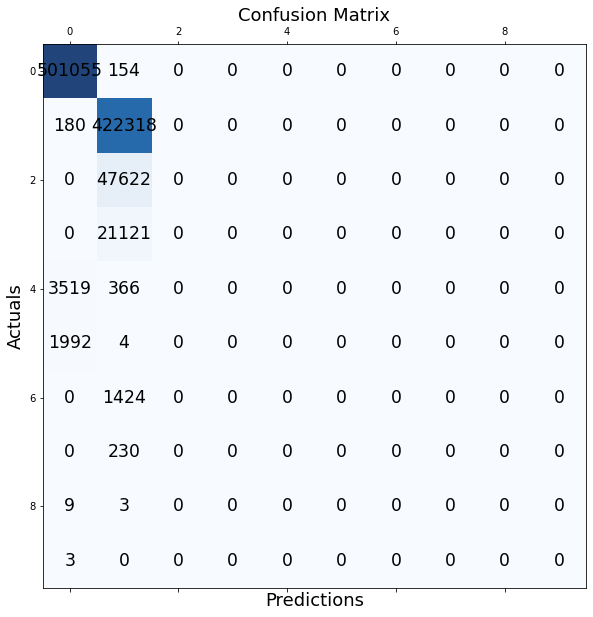

In [15]:
## Part c
# part = 'c'
if part == 'c':
    hidden_layers_list = [[5],[10],[15], [20], [25]]
    train_accs = []
    test_accs  = []
    for hidden_layers in hidden_layers_list:
        print('For hidden layer:-----------------',hidden_layers)
        t1 = datetime.datetime.now()
        nn_model = NN(hidden_layers, lr_rate='normal')
        accuracy_list, error_list = nn_model.fit(X_train[:], Y_train[:], lr=0.1, max_epochs=10000, stopping_val=0.0001)
        t2 = datetime.datetime.now()
        print("Time Taken to train",t2-t1)
        
        print('For Train data:')
        prediction_train = nn_model.predict(X_train)
        train_accs.append(accuracy_score(prediction_train, Y_train))
        print('\tAcuracy:', train_accs[-1])        
        print('For Test data:')
        prediction_test = nn_model.predict(X_test)
        test_accs.append(accuracy_score(prediction_test, Y_test))
        print('\tAcuracy:', test_accs[-1])
        nn_model.confusion_matrix(predictions=prediction_test, labels=Y_test, plot_it=True, path='part_c_hl_'+str(hidden_layers[0])+'.png')
    fig = plt.figure()
    plt.plot(hidden_layers_list, train_accs, '-b', label='train accuracy')
    plt.plot(hidden_layers_list, test_accs , '-r', label='test accuracy' )
    plt.title("Accuracy for different sized hidden layers")
    plt.xlabel("Hidden Layer's size")
    plt.ylabel("Accuracies")
    plt.legend()
    plt.savefig('part_c_Accuracy_diff_sized_hidden_layers.png')
    #plt.show()


For hidden layer:----------------- [5]
total layers: 2
 hidden_layers [5]
 feature_size: 85
epoch 0     | error: 2.276620 | acc: 49.952019 
epoch 100   | error: 1.420297 | acc: 49.952019 
epoch 200   | error: 1.417957 | acc: 50.007997 


KeyboardInterrupt: 

In [17]:
# part = 'd'
if part == 'd':
    hidden_layers_list = [[25], [20], [15], [10], [5]]
    train_accs = []
    test_accs  = []
    for hidden_layers in hidden_layers_list:
        print('For hidden layer:-----------------',hidden_layers)
        t1 = datetime.datetime.now()
        nn_model = NN(hidden_layers, lr_rate='adaptive')
        accuracy_list, error_list = nn_model.fit(X_train[:], Y_train[:], lr=0.1, max_epochs=1000, stopping_val=0.0000001)
        t2 = datetime.datetime.now()
        print("Time Taken to train",t2-t1)
        
        print('For Train data:')
        prediction_train = nn_model.predict(X_train)
        train_accs.append(accuracy_score(prediction_train, Y_train))
        print('\tAcuracy:', train_accs[-1])        
        print('For Test data:')
        prediction_test = nn_model.predict(X_test)
        test_accs.append(accuracy_score(prediction_test, Y_test))
        print('\tAcuracy:', test_accs[-1])
        nn_model.confusion_matrix(predictions=prediction_test, labels=Y_test, plot_it=True, path='part_d_hl_'+str(hidden_layers[0])+'.png')
    fig = plt.figure()
    plt.plot(hidden_layers_list, train_accs, '-b', label='train accuracy')
    plt.plot(hidden_layers_list, test_accs , '-r', label='test accuracy' )
    plt.title("Adaptive lr Accuracy hidden layers")
    plt.xlabel("Hidden Layer's size")
    plt.ylabel("Accuracies")
    plt.legend()
    plt.savefig('part_d_Adaptive_lr_acc_hidden_layers.png')
    #plt.show()

For hidden layer:----------------- [25]
total layers: 2
 hidden_layers [25]
 feature_size: 85
epoch 0     | error: 1.771591 | acc: 49.952019 
epoch 100   | error: 1.421523 | acc: 49.952019 


KeyboardInterrupt: 

In [18]:
##Part e
part = 'e'
if part == 'e':
    print('Part e - Relu')
    print('Using Adaptive rate')
    nn_relu_adap = NN([100, 100], lr_rate='adaptive', activation_m='relu')
    accuracy_list, error_list = nn_relu_adap.fit(X_train[:], Y_train[:], lr=0.1, max_epochs=2200, stopping_val=0.003)
    
    print('For Test data:')
    prediction_test = nn_relu_adap.predict(X_test)
    print('Acuracy:', accuracy_score(prediction_test, Y_test))
    nn_model.confusion_matrix(predictions=prediction_test, labels=Y_test, plot_it=True, path= 'part_e_relu_adap.png')
    
    print('\nUsing Constant learning rate')
    nn_relu_const = NN([100, 100], lr_rate='normal', activation_m='relu')
    accuracy_list, error_list = nn_relu_const.fit(X_train[:], Y_train[:], lr=0.1, max_epochs=800, stopping_val=0.003)
    
    print('For Test data:')
    prediction_test = nn_relu_const.predict(X_test)
    print('Acuracy:', accuracy_score(prediction_test, Y_test))
    nn_model.confusion_matrix(predictions=prediction_test, labels=Y_test, plot_it=True, path= 'part_e_relu_const.png')

Part e - Relu
Using Adaptive rate
total layers: 3
 hidden_layers [100, 100]
 feature_size: 85
epoch 0     | error: 2.598367 | acc: 46.761295 
epoch 100   | error: 2.103101 | acc: 52.115154 


KeyboardInterrupt: 

In [507]:
# y_df.describe()
# y_df.value_counts()

,0
count,25010.000000
mean,0.621152
std,0.788361
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,9.000000


In [ ]:
# pred = nn_model.forward_pass(X_train[:200])
# pred = np.argmax(pred, axis=1)
# ohe_pred = ohe_y.transform(pred.reshape(-1,1)).toarray()
# print('ohe pred', ohe_pred.shape)
# print('ohe y', Y_train_ohe[:200].shape)
# acc1 = accuracy_score(ohe_pred, Y_train_ohe[:200])
# acc2 = accuracy_score(pred, Y_train[:200])
# print(acc1, acc2)